
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

In [4]:
import numpy as np
import mne
from tinnsleep.reports import combine_brux_MEMA, generate_bruxism_report, generate_MEMA_report
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tinnsleep.config import Config
import scipy
print("Config loaded")


Config loaded


## Loading parameters and results

In [7]:


# change to --overwrite True if you want to force to recompute the results
#%run ../compute_results.py --bruxism True --mema True --overwrite False 

#mema_files= pd.read_csv("data/mema_files.csv",engine='python', sep=", ")["files_with_mema"].values

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0
EDF_list = Config.bruxisme_files
print(EDF_list)

['F:/Acou_sommeil/EDF_renom\\1AC26_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1BA07_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1BA07_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1CB23_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1CC05_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1CC05_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DA15_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1DA15_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DL12_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1DL12_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DM32_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1GB18_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1GB18_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_1.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_1_resmed.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_2.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_2_resmed.edf', 'F:/Acou_sommeil/

## Bruxism + MEMA processing for pure MEMA visualisation

In [8]:
from time import time
# load file from config

ind_THR_brux=-1
ind_THR_MEMA = 0

start = time()
results_brux_combine={}
results_brux_pure={}
results_MEMA_combine={}
results_MEMA_pure={}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list:
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        if not (file in results_brux.keys() and file in results_MEMA.keys()):
            #print(results_brux[file]["parameters"]["time_interval"])
            print(f"(does not have both bruxism and mema)... skipping")
        else:
            window_length_brux = results_brux[file]["parameters"]["time_interval"]
            delim_brux = results_brux[file]["parameters"]["delim"]
            window_length_MEMA = results_MEMA[file]["parameters"]["time_interval"]
            delim_MEMA = results_MEMA[file]["parameters"]["delim"]
            params_combine = dict(
                                labels_brux = results_brux[file]["labels"][ind_THR_brux], 
                                time_interval_brux = results_brux[file]["parameters"]["time_interval"], 
                                delim_ep_brux = results_brux[file]["parameters"]["delim"], 
                                labels_MEMA = results_MEMA[file]["labels"][ind_THR_MEMA],
                                time_interval_MEMA = results_MEMA[file]["parameters"]["time_interval"],
                                delim_ep_MEMA = results_brux[file]["parameters"]["delim"],
                                min_burst_joining_brux=min_burst_joining_brux, 
                                min_burst_joining_MEMA=min_burst_joining_MEMA
                                )
            print(results_MEMA[file]["parameters"]["time_interval"])
            print(len(results_brux[file]["labels"][0]))
            print(np.sum(results_brux[file]["labels"][0]))
            print(results_brux[file]["reports"][0])
            print(len(results_MEMA[file]["labels"][0])*4)
            print(results_brux[file]["parameters"]["time_interval"])
            
            brux_comb_ep, brux_pure_ep, MEMA_comb_ep, MEMA_pure_ep = combine_brux_MEMA(**params_combine)
            

            
            results_brux_combine[file]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [brux_comb_ep]     ,              
                "reports": [generate_bruxism_report(brux_comb_ep, window_length_brux, delim_brux, min_burst_joining=0)]
                }
            
            results_brux_pure[file]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [brux_pure_ep]     ,              
                "reports": [generate_bruxism_report(brux_pure_ep, window_length_brux, delim_brux, min_burst_joining=0)]
                }
            

            results_MEMA_combine[file]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                 "labels":  [MEMA_comb_ep]     ,              
                "reports": [generate_MEMA_report(MEMA_comb_ep, window_length_brux, delim_MEMA)]}
            
            results_MEMA_pure[file]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                 "labels": [ MEMA_pure_ep  ]   ,              
                "reports": [generate_MEMA_report(MEMA_pure_ep, window_length_brux, delim_MEMA)]}
            
            print("heu")
            print(len(MEMA_comb_ep))
            print(np.sum(brux_comb_ep))
            print(np.sum(brux_pure_ep))
            print(window_length_brux)
            print(delim_brux)
            print(min_burst_joining_brux)
            
            pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
            li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= 0)#important!!
            pure_brux_events = episodes_to_list(li_ep_brux_p, window_length_brux, len(brux_pure_ep))
            
            comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
            li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= 0) #Important!!
            comb_brux_events = episodes_to_list(li_ep_brux_c, window_length_brux, len(brux_comb_ep))
            
            comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?
            
            print("rapport d'activité : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts))

            
            print("rapport d'activité taux horaire : ")
            print("nb episodes bruxisme combinés : ")
            print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes bruxisme purs : ")
            print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("nb episodes MEMA combinés : ")
            print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            print("Nb épisodes MEMA purs : ")
            print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
            
            new_l_comb=[]
            for i in range(len(MEMA_comb_ep)):
                if MEMA_comb_ep[i]:
                    new_l_comb.append(3)
                else:
                    new_l_comb.append(0)
                    
            new_l_pure=[]
            for i in range(len(MEMA_pure_ep)):
                if MEMA_pure_ep[i]:
                    new_l_pure.append(2)
                else:
                    new_l_pure.append(0)
                    
            for i in range(len(comb_brux_events)):
                if comb_brux_events[i]>0:
                    comb_brux_events[i]=4
                    
            for i in range(len(pure_brux_events)):
                if pure_brux_events[i]>0:
                    pure_brux_events[i]=5
                    
            plt.figure()
            plt.plot(pure_brux_events, label="pure_brux")
            plt.plot(comb_brux_events, label="comb_brux")
            plt.plot(new_l_comb, label="comb_MEMA")
            plt.plot(new_l_pure, label="pure_MEMA")
            plt.legend()
            plt.title("Where the events happen for " + file)


pd.DataFrame.from_dict(results_brux_combine).to_pickle("data/reports_and_datas_bruxism_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_brux_pure).to_pickle("data/reports_and_datas_bruxism_pure.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_combine).to_pickle("data/reports_and_datas_MEMA_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_pure).to_pickle("data/reports_and_datas_MEMA_pure.pk", protocol=3)
print("results saved!!")

Files processed : 
1AC26_cohort2.edf (does not have both bruxism and mema)... skipping
1BA07_nuit_hab.edf (does not have both bruxism and mema)... skipping
1BA07_nuit_son.edf (does not have both bruxism and mema)... skipping
1CB23_cohort2.edf (does not have both bruxism and mema)... skipping
1CC05_nuit_hab.edf (does not have both bruxism and mema)... skipping
1CC05_nuit_son.edf (does not have both bruxism and mema)... skipping
1DA15_nuit_hab.edf (does not have both bruxism and mema)... skipping
1DA15_nuit_son.edf (does not have both bruxism and mema)... skipping
1DL12_nuit_hab.edf (does not have both bruxism and mema)... skipping
1DL12_nuit_son.edf (does not have both bruxism and mema)... skipping
1DM32_cohort2.edf (does not have both bruxism and mema)... skipping
1GB18_nuit_hab.edf (does not have both bruxism and mema)... skipping
1GB18_nuit_son.edf (does not have both bruxism and mema)... skipping
1GF14_cohort2.edf (does not have both bruxism and mema)... skipping
1GF14_nuit_hab.edf 

TypeError: generate_bruxism_report() missing 1 required positional argument: 'valid_labels'

## Display of the last computed recording

In [39]:
labels_int= results_brux[file]["labels"][0]
int_bursts = classif_to_burst(labels_int, time_interval=window_length_brux)
li_ep_int = burst_to_episode(int_bursts, delim=delim_brux, min_burst_joining= min_burst_joining_brux)
print("nb episodes")
print(len(li_ep_int))
pure_int_events = episodes_to_list(li_ep_int, window_length_brux, len(brux_pure_ep))
print(file)
print(filename)
duration_brux = 200*0.25
print(np.sum(labels_int))
print(len(labels_int)*48)

interval_brux = duration_brux
print (len(MEMA_comb_ep))
#print(len(raw))
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Airflow', '1', '2', "Activity"]           # subset of EMG electrodes
raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
print(raw.info["sfreq"])

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=['misc','emg','emg', "misc"])        # pick channels and load
print(len(raw))
scalings = dict(misc=1, emg=1e-5)

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"b_comb", 3:"M_pure", 4:"M_comb"}
#raw = AnnotateRaw_sliding(raw, MEMA_comb_ep , 
#                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw,  comb_brux_events, 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)


print("Raw annotated")
scalings = {'emg': 5e-5, 'misc': 0.2, 'bio':1e3}
raw.plot(scalings = scalings)
plt.title(filename)
                    

nb episodes
222
1GB19_nuit_hab.edf
E:/Acou_sommeil/EDF_V2_PAUL\1GB19_nuit_hab.edf
11292
6107520
127240


<ipython-input-39-f8b7121371f3>:19: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading


200.0
6362000
Raw annotated


Text(0.5, 1, 'E:/Acou_sommeil/EDF_V2_PAUL\\1GB19_nuit_hab.edf')

## Analysis 

In [8]:
#Here replace with the metric to analyse
results = results_MEMA_pure
THR_classif = results[list(results.keys())[0]]["THR_classif"]

In [9]:
get_scores=[]
for elm in results.keys():
        print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            print(ep["Number of MEMA episodes per hour"])
            
            l_ep_h.append(ep["Number of MEMA episodes per hour"])
        print(ep.keys())

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores)

1DA15_nuit_hab.edf
29.357798165137616
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1GB19_nuit_hab.edf
30.443256837472493
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1MF19_nuit_hab.edf
11.609336609336609
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
HZB_nuit_1.edf
18.35236541598695
dict_keys(['Clean MEMA duration', 'Total MEMA burst 

In [10]:
get_masking = pd.read_csv("data/evol_masquage.csv", delimiter=";")
#print(get_masking)
get_VAS_L = pd.read_csv("data/evol_eva_I.csv", delimiter=";")
#print(get_VAS_L)
get_VAS_I = pd.read_csv("data/evol_eva_G.csv", delimiter=";")
#print(get_VAS_I)

evol_masking = get_masking.values.tolist()[:-4]
evol_VAS_L = get_VAS_L.values.tolist()
evol_VAS_I = get_VAS_I.values.tolist()

1DA15_nuit_hab.edf
1GB19_nuit_hab.edf
HZB_nuit_1.edf
HZB_nuit_2.edf
SCHM_nuit_2.edf
Unger_2.edf
unger_nuit_1.edf
Nb_patients in each group : 
Tinnitus increase : 2
Tinnitus stable : 3
tinnitus decrease : 2
Healthy subjects : 4


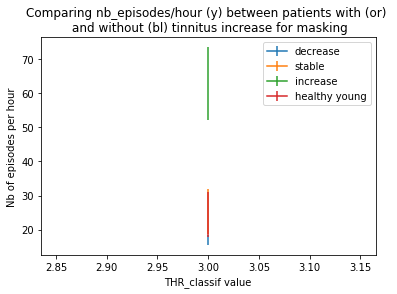

In [11]:
# Files not to consider for analysis
to_suppress=["1MA16_nuit_hab.edf","SCHM_nuit_1.edf","HZB_nuit_3.edf", "1MF19_nuit_hab.edf",
            "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_5_dec_OD__0to1.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf",
             "SCHMIDTLIN_nuit_4_dec_OD__3to3.edf",]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 
patients_sains=['jon_mema.edf','robin_mema_nuit_2.edf','sophie_mema.edf','tom_mema.edf']
#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable
decrease = [[] for i in range(len(THR_classif))] #patients with decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        
        if elm[0]==get_scores[i][0]:
            print(elm[0])
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
                    
scores_sains=[[] for i in range(len(THR_classif))]
for elm in get_scores:
    if patients_sains.__contains__(elm[0]):
        for j in range(len(THR_classif)):
            scores_sains[j].append(elm[1][j])
scores_sains_m=[]
scores_sains_std=[]
for elm in scores_sains:
    scores_sains_m.append(np.mean(elm))
    scores_sains_std.append(np.std(elm))
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+3 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+3 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+3 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+3 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()

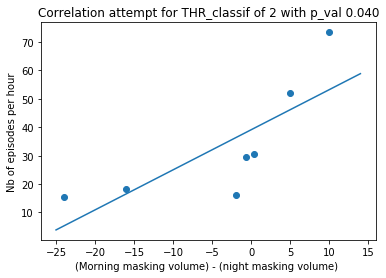

In [12]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

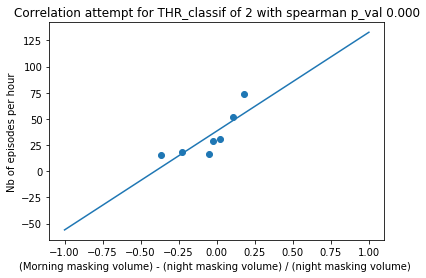

In [13]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with spearman p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

In [ ]:
#VAS L

Nb_patients in each group : 
Tinnitus increase : 3
Tinnitus stable : 3
tinnitus decrease : 4
Healthy subjects : 4


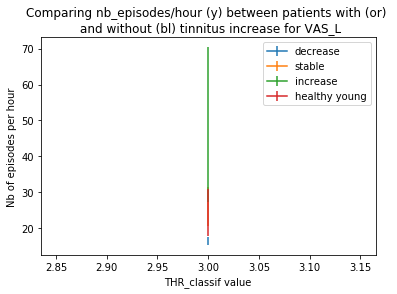

In [14]:
#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_L:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
                
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
                    
scores_sains=[[] for i in range(len(THR_classif))]
for elm in get_scores:
    if patients_sains.__contains__(elm[0]):
        for j in range(len(THR_classif)):
            scores_sains[j].append(elm[1][j])
scores_sains_m=[]
scores_sains_std=[]
for elm in scores_sains:
    scores_sains_m.append(np.mean(elm))
    scores_sains_std.append(np.std(elm))
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+3 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+3 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+3 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+3 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()            



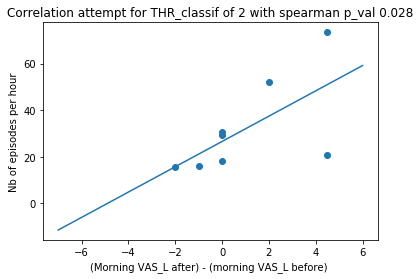

In [15]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with spearman p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

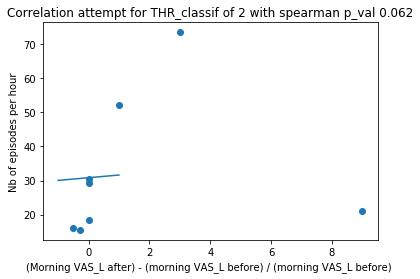

In [16]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with spearman p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) / (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

In [ ]:
#VAS I

1DA15_nuit_hab.edf
1GB19_nuit_hab.edf
HZB_nuit_1.edf
HZB_nuit_2.edf
SCHM_nuit_2.edf
SCHM_nuit_3.edf
Unger_2.edf
unger_nuit_1.edf
Nb_patients in each group : 
Tinnitus increase : 4
Tinnitus stable : 2
tinnitus decrease : 6
Healthy subjects : 4


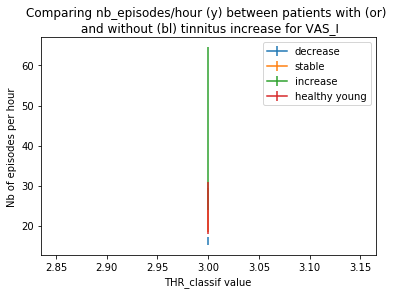

In [17]:
#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_I:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            print(elm[0])
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0.1):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                if (elm[2]<-0.1):
                    for j in range(len(THR_classif)):
                        decrease[j].append(get_scores[i][1][j])
                else:
                    for j in range(len(THR_classif)):
                        stable[j].append(get_scores[i][1][j])
                    
scores_sains=[[] for i in range(len(THR_classif))]
for elm in get_scores:
    if patients_sains.__contains__(elm[0]):
        for j in range(len(THR_classif)):
            scores_sains[j].append(elm[1][j])
scores_sains_m=[]
scores_sains_std=[]
for elm in scores_sains:
    scores_sains_m.append(np.mean(elm))
    scores_sains_std.append(np.std(elm))
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
decrease_m=[]
decrease_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
for elm in decrease:
    decrease_m.append(np.mean(elm))
    decrease_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
print("tinnitus decrease : " + str(len(decrease[0])))
print("Healthy subjects : " + str(len(scores_sains[0])))

    
#Displaying
plt.figure()
plt.errorbar([i+3 for i in range(len(THR_classif))],decrease_m, decrease_std, label = "decrease")
plt.errorbar([i+3 for i in range(len(THR_classif))],stable_m, stable_std, label = "stable")
plt.errorbar([i+3 for i in range(len(THR_classif))], augm_m, augm_std, label = "increase")
plt.errorbar([i+3 for i in range(len(THR_classif))], scores_sains_m, scores_sains_std, label = "healthy young")
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_I" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')
plt.legend()            



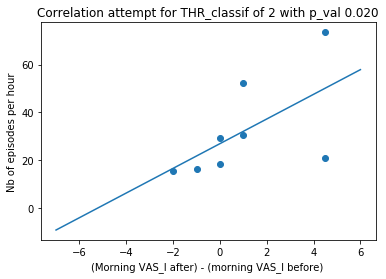

In [18]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

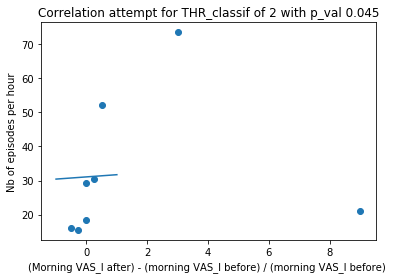

In [19]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    spear = scipy.stats.spearmanr(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % spear[1]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) / (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')